In [3]:
import os
import zipfile
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from sklearn.cluster import KMeans
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import optimizers
from tensorflow.keras import Model

In [5]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 4.7 MB/s eta 0:00:00


In [6]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
local_zip = 'Alzheimer_s_Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./tmp')
zip_ref.close()
%ls ./tmp/Alzheimer_s_Dataset/

test/  train/


In [9]:
BATCH_SIZE = 32
# IMAGE_SIZE = [176,208]
IMAGE_WIDTH = 176
IMAGE_HEIGHT = 208

CHANNELS=3
EPOCHS=50

In [10]:
train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    "./tmp/Alzheimer_s_Dataset/train/",
    validation_split=0.2,
    subset="training",
    shuffle=True,
    seed=1337,
    image_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./tmp/Alzheimer_s_Dataset/train/",
    validation_split=0.2,
    subset="validation",
    shuffle=False,
    seed=1337,
    image_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size=BATCH_SIZE
)

test_ds= tf.keras.preprocessing.image_dataset_from_directory(
    "./tmp/Alzheimer_s_Dataset/test/",
    shuffle=False,
    seed=1337,
    image_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size=BATCH_SIZE
)





Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


In [11]:
class_names = train_ds.class_names
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
NUM_CLASSES = len(class_names)
print('number of classes: ',NUM_CLASSES)

number of classes:  4


In [ ]:
len(train_ds)

129

In [ ]:
129*32

4128

In [ ]:
len(val_ds)

32

In [ ]:
32*32

1024

In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch.numpy())

(32, 176, 208, 3)
(32,)
[3 0 3 2 3 2 2 2 3 2 2 2 2 2 2 3 0 2 2 2 3 2 3 3 2 3 2 2 2 3 2 3]


In [ ]:
print(image_batch[0].shape)

(176, 208, 3)


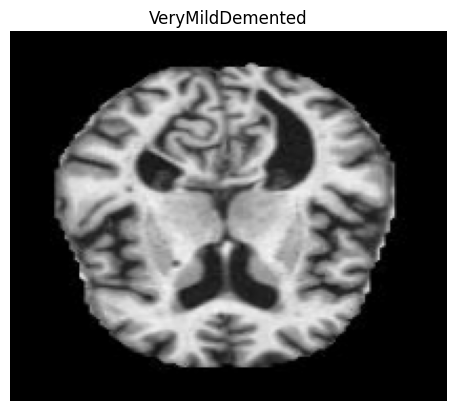

In [ ]:
for image_batch, labels_batch in train_ds.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8'))
  plt.title(class_names[labels_batch[0]])
  plt.axis('off')

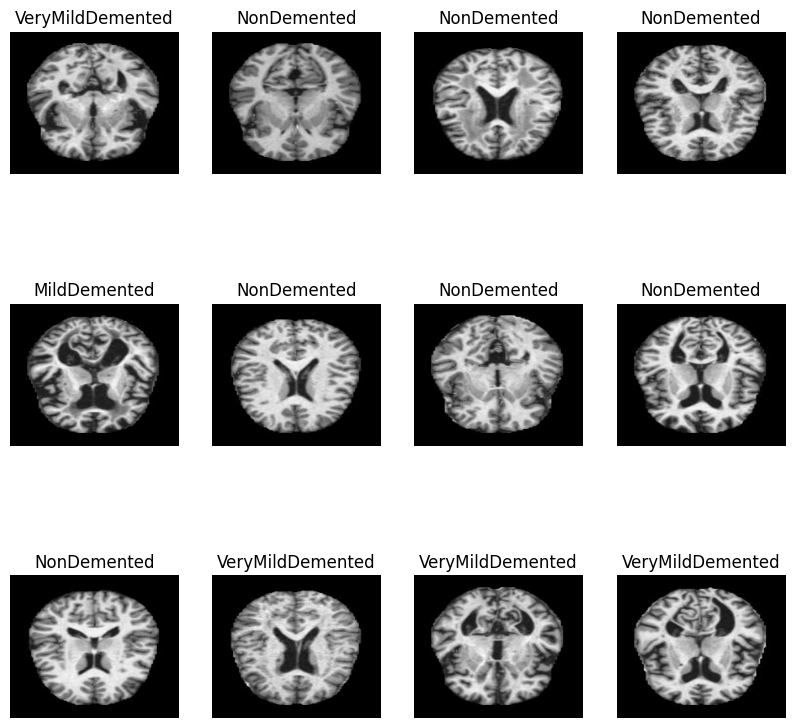

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):

    for i in range(12):

        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
NUM_IMAGES = {}
for label in class_names:
    dir_name = "./tmp/Alzheimer_s_Dataset/train/" + label[:-2] + 'ed'
    # print(dir_name)
    # print(label[:-2] + 'ed')
    NUM_IMAGES.update({label[:-2] + 'ed' : len([name for name in os.listdir(dir_name)])})
print('Number of images in each class',NUM_IMAGES)

Number of images in each class {'MildDemented': 717, 'ModerateDemented': 52, 'NonDemented': 2560, 'VeryMildDemented': 1792}


This is a very imbalanced dataset as 'MODERATE DEMENTED' is very under represented compared to other classes.

SO ,i am calculating class weights for individual classes and add it during training  to try to balance the classes.

There are more sophisticated techniques available, which i will try in the upcoming notebooks

In [ ]:
## Calculate class weights.

total = sum(NUM_IMAGES.values())
number_of_classes = len(NUM_IMAGES)
print('total images',total)
print('no of images',number_of_classes)

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(NUM_IMAGES.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

total images 5121
no of images 4
Weight for class "MildDemented" : 1.79
Weight for class "ModerateDemented" : 24.62
Weight for class "NonDemented" : 0.5
Weight for class "VeryMildDemented" : 0.71


**TENSORFLOW PIPELINE**

Tensorflow pipeline helps to efficiently load and preprocess data for large datasets.

This delivers data for the next step before the current step has been finished.

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
print(BATCH_SIZE)

32


In [ ]:
input_shape = (BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
n_classes = 4


In [ ]:
model1 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu',padding='same' ,input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3),padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model1.build(input_shape=input_shape)

In [ ]:
model1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 176, 208, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 176, 208, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 88, 104, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 88, 104, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 44, 52, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 44, 52, 64)         

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# train the network

history1 = model1.fit(train_ds,
                    validation_data = val_ds,
                    batch_size = 32,
                    epochs = 20,
                    callbacks = [early_stopping])


Epoch 1/20
129/129 [==============================] - 383s 3s/step - loss: 1.0583 - accuracy: 0.4845 - val_loss: 1.1741 - val_accuracy: 0.0000e+00
Epoch 2/20
129/129 [==============================] - 352s 3s/step - loss: 1.0316 - accuracy: 0.4996 - val_loss: 1.0795 - val_accuracy: 0.0000e+00
Epoch 3/20
129/129 [==============================] - 378s 3s/step - loss: 0.9804 - accuracy: 0.5099 - val_loss: 0.9737 - val_accuracy: 0.8311
Epoch 4/20
129/129 [==============================] - 371s 3s/step - loss: 0.9041 - accuracy: 0.5519 - val_loss: 0.7484 - val_accuracy: 0.7432
Epoch 5/20
129/129 [==============================] - 371s 3s/step - loss: 0.8645 - accuracy: 0.5733 - val_loss: 1.2033 - val_accuracy: 0.2725
Epoch 6/20
129/129 [==============================] - 370s 3s/step - loss: 0.7995 - accuracy: 0.6200 - val_loss: 0.9034 - val_accuracy: 0.6611
Epoch 7/20
129/129 [==============================] - 354s 3s/step - loss: 0.6955 - accuracy: 0.6829 - val_loss: 1.5800 - val_accuracy

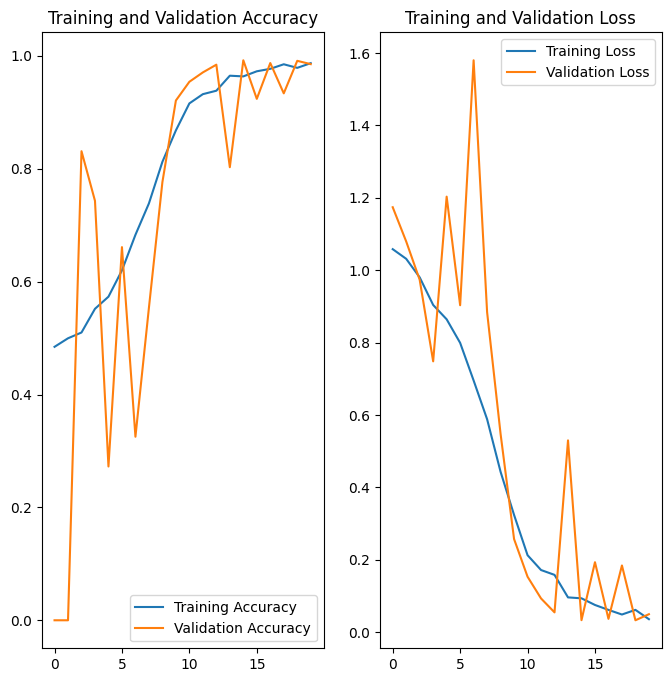

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model1.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 1s 705ms/step


In [ ]:
print(confusion_matrix(correct_labels, predicted_labels))

[[ 562    1    1    2]
 [   0   43    0    0]
 [   0    0 2053    0]
 [   0    0    2 1433]]


In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model1.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 1s 1s/step


In [ ]:
print(confusion_matrix(correct_labels, predicted_labels))

[[ 51   0  37  91]
 [  0   2   2   8]
 [  0   0 419 221]
 [ 13   0 119 316]]


In [ ]:
print(classification_report(correct_labels, predicted_labels,
                            target_names=["class 1", "class 2", "class 3", "class 4"]))

              precision    recall  f1-score   support

     class 1       0.80      0.28      0.42       179
     class 2       1.00      0.17      0.29        12
     class 3       0.73      0.65      0.69       640
     class 4       0.50      0.71      0.58       448

    accuracy                           0.62      1279
   macro avg       0.75      0.45      0.49      1279
weighted avg       0.66      0.62      0.61      1279



In [ ]:
scores = model1.evaluate(test_ds)

40/40 [==============================] - 30s 743ms/step - loss: 2.1363 - accuracy: 0.6161


For model1, even though validation accuracy is high, the model doesn't perform well when it sees new images from the test dataset.
F1 score for  class 2 is visibly very low as they are under represented.


**RESNET MODEL**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input

In [ ]:
train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    "./tmp/Alzheimer_s_Dataset/train/",
    validation_split=0.2,
    subset="training",
    shuffle=True,
    seed=1337,
    image_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./tmp/Alzheimer_s_Dataset/train/",
    validation_split=0.2,
    subset="validation",
    shuffle=False,
    seed=1337,
    image_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size=BATCH_SIZE
)

test_ds= tf.keras.preprocessing.image_dataset_from_directory(
    "./tmp/Alzheimer_s_Dataset/test/",
    shuffle=False,
    seed=1337,
    image_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size=BATCH_SIZE
)





Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


**Using resnet50.preprocess_input for pre processing input images**

In [ ]:
def preprocess(images, labels):
    images= tf.keras.applications.resnet50.preprocess_input(images)
    images=tf.image.adjust_brightness(images,0.2)
    return images, labels

train_ds=train_ds.map(preprocess)

In [ ]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.map_op._MapDataset'>


In [ ]:
def display(ds):
  images, _ = next(iter(ds.take(1)))
  image = images[0].numpy()
  image /= 255.0
  plt.imshow(image)

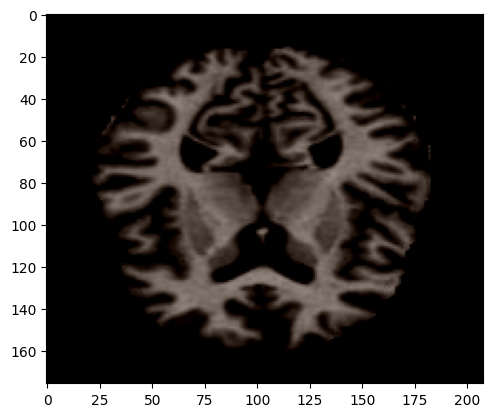

In [ ]:
display(train_ds)

In [ ]:
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

**TENSOR FLOW INPUT PIPELINE**

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


**ResNet50 for feature extraction**

In [ ]:
input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS)
# network architecture

rn50 = ResNet50(input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,CHANNELS), include_top = False)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
#freeze all layers
for layer in rn50.layers:
    layer.trainable = False

x = layers.Flatten()(rn50.output)
x = layers.Dense(1000, activation='relu')(x)
output = layers.Dense(4, activation = 'softmax')(x)


In [ ]:
from tensorflow.keras import Model

In [ ]:
model2 = Model(inputs = rn50.inputs, outputs = output)

# compile network

model2.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# view network architecture

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 182, 214, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 88, 104, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 88, 104, 64)  256         ['conv1_conv[0][0]']         

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# train the network

history2 = model2.fit(train_ds,
                    validation_data = val_ds,
                    batch_size = BATCH_SIZE,
                    epochs = 20,
                    callbacks = [early_stopping],class_weight=class_weights)


Epoch 1/20
129/129 [==============================] - 851s 6s/step - loss: 57.4447 - accuracy: 0.4206 - val_loss: 2.9528 - val_accuracy: 0.4844
Epoch 2/20
129/129 [==============================] - 848s 7s/step - loss: 2.5575 - accuracy: 0.6305 - val_loss: 1.3096 - val_accuracy: 0.5684
Epoch 3/20
129/129 [==============================] - 860s 7s/step - loss: 0.3122 - accuracy: 0.8362 - val_loss: 0.1228 - val_accuracy: 0.9561
Epoch 4/20
129/129 [==============================] - 837s 7s/step - loss: 0.2076 - accuracy: 0.8909 - val_loss: 0.3929 - val_accuracy: 0.8408
Epoch 5/20
129/129 [==============================] - 832s 6s/step - loss: 0.0582 - accuracy: 0.9753 - val_loss: 0.0705 - val_accuracy: 0.9824
Epoch 6/20
129/129 [==============================] - 828s 6s/step - loss: 0.0318 - accuracy: 0.9939 - val_loss: 0.0814 - val_accuracy: 0.9717
Epoch 7/20
129/129 [==============================] - 830s 6s/step - loss: 0.0221 - accuracy: 0.9990 - val_loss: 0.0658 - val_accuracy: 0.980

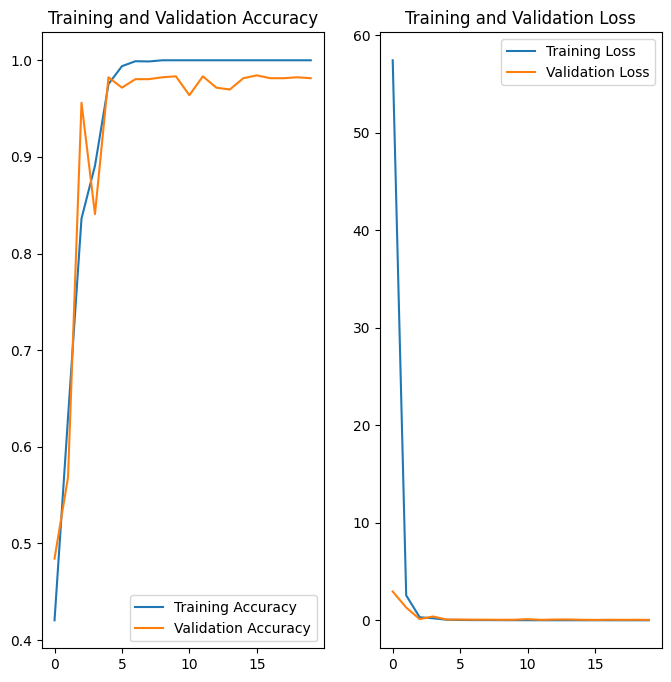

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
scores = model2.evaluate(test_ds)

40/40 [==============================] - 180s 4s/step - loss: 1.5385 - accuracy: 0.6489


In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model2.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 5s 5s/step


In [ ]:
print(confusion_matrix(correct_labels, predicted_labels))

[[ 43   0  36 100]
 [  2   2   0   8]
 [  8   0 410 222]
 [ 11   0  62 375]]


In [ ]:
print(classification_report(correct_labels, predicted_labels,
                            target_names=["class 1", "class 2", "class 3", "class 4"]))

              precision    recall  f1-score   support

     class 1       0.67      0.24      0.35       179
     class 2       1.00      0.17      0.29        12
     class 3       0.81      0.64      0.71       640
     class 4       0.53      0.84      0.65       448

    accuracy                           0.65      1279
   macro avg       0.75      0.47      0.50      1279
weighted avg       0.69      0.65      0.64      1279



Even with using Resnet 50 for pre processing and for feature extraction , the model doesn't perform well with test data set.
Steps to improve the model performance would be,
1. Gathering more images in each class from different places for better training the model.
2. Using data augmentation to address the problem of less images .
3.Using more sophisticated techniques like the Synthetic Minority Over-sampling Technique (SMOTE)  for class imbalance.
4.Most importantly, **domain knowledge** is important.

The medial temporal and the hippocampus lobe are the first regions of the brain that will be affected, and they can be detected on MRI.So based on domain knowledge right features should be extracted for training.
Various types of brain segmentation techniques can be tried to extract the right features that shows the shrinkage in the brain , which is necessary for proper detection.
